# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

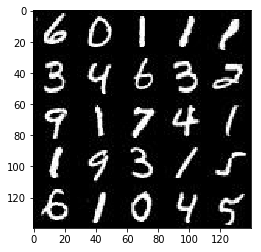

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

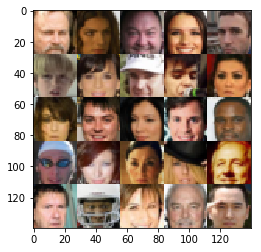

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def lrelu(x, alpha):
    return tf.maximum(x, alpha * x)

In [7]:
def discriminator(images, alpha, reuse=False, keep_prob=0.95):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = lrelu(x1, alpha)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = lrelu(tf.layers.batch_normalization(x2, training=True), alpha)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = lrelu(tf.layers.batch_normalization(x3, training=True), alpha)
#         print("x3: ", x3)
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = lrelu(tf.layers.batch_normalization(x4, training=True), alpha)
#         print("x4: ", x4)
    
        flat = tf.reshape(x4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
#         logits = tf.nn.dropout(logits, keep_prob)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

x0:  Tensor("Maximum:0", shape=(?, 14, 14, 128), dtype=float32)
x1:  Tensor("Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
x2:  Tensor("Maximum_2:0", shape=(?, 4, 4, 1024), dtype=float32)
x0:  Tensor("Maximum_3:0", shape=(?, 14, 14, 128), dtype=float32)
x1:  Tensor("Maximum_4:0", shape=(?, 7, 7, 256), dtype=float32)
x2:  Tensor("Maximum_5:0", shape=(?, 4, 4, 1024), dtype=float32)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, alpha, is_train=True, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        # layer 0 - out:7x7x512
        x0 = tf.layers.dense(z, 7*7*512)
        x0 = tf.reshape(x0, (-1, 7, 7, 512))
        x0 = lrelu(tf.layers.batch_normalization(x0, training=is_train), alpha)
                
        # layer 1 - out: 14x14x256
        x1 = tf.layers.conv2d_transpose(x0, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = lrelu(tf.layers.batch_normalization(x1, training=is_train), alpha)
#         print("x1: ", x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 3, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = lrelu(tf.layers.batch_normalization(x2, training=is_train), alpha)
#         print("x2: ", x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = lrelu(tf.layers.batch_normalization(x3, training=is_train), alpha)
#         print("x3: ", x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 3, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = lrelu(tf.layers.batch_normalization(x4, training=is_train), alpha)
#         print("x4: ", x4)
        
        # output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

x0:  Tensor("Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
x1:  Tensor("Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
x0:  Tensor("Maximum_2:0", shape=(?, 7, 7, 512), dtype=float32)
x1:  Tensor("Maximum_3:0", shape=(?, 14, 14, 256), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, alpha, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, alpha, reuse=True)
    
    d_real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    d_fake_labels = tf.zeros_like(d_model_fake)
    g_labels = tf.ones_like(d_model_fake)
    
    d_cross_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_labels)
    d_cross_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_labels)
    g_cross = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels)
    
    d_loss = tf.reduce_mean(d_cross_real) + tf.reduce_mean(d_cross_fake)
    g_loss = tf.reduce_mean(g_cross)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

x0:  Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
x1:  Tensor("generator/Maximum_1:0", shape=(?, 14, 14, 256), dtype=float32)
x0:  Tensor("discriminator/Maximum:0", shape=(?, 14, 14, 128), dtype=float32)
x1:  Tensor("discriminator/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
x2:  Tensor("discriminator/Maximum_2:0", shape=(?, 4, 4, 1024), dtype=float32)
x0:  Tensor("discriminator_1/Maximum:0", shape=(?, 14, 14, 128), dtype=float32)
x1:  Tensor("discriminator_1/Maximum_1:0", shape=(?, 7, 7, 256), dtype=float32)
x2:  Tensor("discriminator_1/Maximum_2:0", shape=(?, 4, 4, 1024), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        
#     update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     g_update_ops = [update for update in update_ops if update.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):       
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
        d_min_opt = d_train_opt.minimize(d_loss, var_list=d_vars) 
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
        g_min_opt = g_train_opt.minimize(g_loss, var_list=g_vars)
    
        return d_min_opt, g_min_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, alpha):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, alpha, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
!mkdir 'checkpoints'

mkdir: cannot create directory ‘checkpoints’: File exists


In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha,
          show_every_n=10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    img_width, img_height, img_depth = data_shape[1:]
    
    input_r, input_z, learning_rate_ = model_inputs(img_width, img_height, img_depth, z_dim)
    
    d_loss, g_loss = model_loss(input_r, input_z, img_depth)
    
    d_min_opt, g_min_opt = model_opt(d_loss, g_loss, learning_rate_, beta1)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # scale images
                batch_images = batch_images * 2.0
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                sess.run(d_min_opt, feed_dict={input_r: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                for i in range(5):
                    sess.run(g_min_opt, feed_dict={input_r: batch_images,
                                                   input_z: batch_z,
                                                   learning_rate_: learning_rate})
             
                if steps % (show_every_n * 10) == 0:
                    show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
            
                if steps % show_every_n == 0:
                    # At the end of each epoch, get the losses and print them out
                    d_train_loss = d_loss.eval({input_z: batch_z, input_r: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {:4}/{}\tD Loss: {:>.4f}\tG Loss: {:>.4f}".format(epoch_i + 1, 
                                                                                     epochs, 
                                                                                     d_train_loss,
                                                                                     g_train_loss))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch    1/2	D Loss: 0.6734	G Loss: 1.8488
Epoch    1/2	D Loss: 0.9849	G Loss: 0.9499
Epoch    1/2	D Loss: 2.5718	G Loss: 12.1631
Epoch    1/2	D Loss: 0.5838	G Loss: 7.6770
Epoch    1/2	D Loss: 0.5079	G Loss: 2.0630
Epoch    1/2	D Loss: 0.4045	G Loss: 6.5284
Epoch    1/2	D Loss: 0.5272	G Loss: 10.2360
Epoch    1/2	D Loss: 0.3947	G Loss: 5.2119
Epoch    1/2	D Loss: 0.4523	G Loss: 3.5155


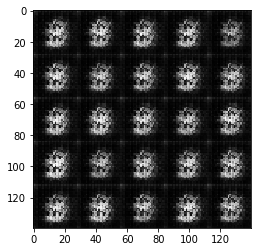

Epoch    1/2	D Loss: 0.4407	G Loss: 2.8423
Epoch    1/2	D Loss: 1.0606	G Loss: 7.5540
Epoch    1/2	D Loss: 0.3659	G Loss: 5.1037
Epoch    1/2	D Loss: 0.7239	G Loss: 1.4761
Epoch    1/2	D Loss: 0.6631	G Loss: 5.4471
Epoch    1/2	D Loss: 0.4825	G Loss: 2.3236
Epoch    1/2	D Loss: 0.5324	G Loss: 2.8917
Epoch    1/2	D Loss: 0.4273	G Loss: 3.6681
Epoch    1/2	D Loss: 0.6665	G Loss: 1.4671
Epoch    1/2	D Loss: 0.4649	G Loss: 3.0126


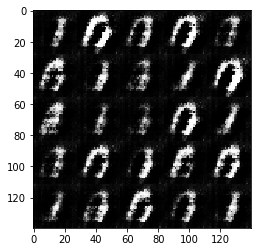

Epoch    1/2	D Loss: 0.8249	G Loss: 2.8472
Epoch    1/2	D Loss: 0.5311	G Loss: 2.3100
Epoch    1/2	D Loss: 0.5258	G Loss: 2.4437
Epoch    1/2	D Loss: 0.5510	G Loss: 1.9847
Epoch    1/2	D Loss: 0.6457	G Loss: 2.7695
Epoch    1/2	D Loss: 0.4796	G Loss: 2.8827
Epoch    1/2	D Loss: 0.6178	G Loss: 4.6160
Epoch    1/2	D Loss: 0.4621	G Loss: 3.3919
Epoch    1/2	D Loss: 0.6645	G Loss: 3.0275
Epoch    1/2	D Loss: 1.5253	G Loss: 1.5208


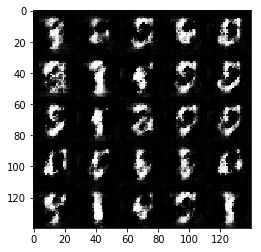

Epoch    1/2	D Loss: 0.5740	G Loss: 3.2104
Epoch    1/2	D Loss: 0.9004	G Loss: 3.1983
Epoch    1/2	D Loss: 0.8433	G Loss: 1.1956
Epoch    1/2	D Loss: 0.8656	G Loss: 1.6543
Epoch    1/2	D Loss: 0.8670	G Loss: 1.1427
Epoch    1/2	D Loss: 0.9314	G Loss: 2.3546
Epoch    1/2	D Loss: 0.5226	G Loss: 2.5310
Epoch    1/2	D Loss: 0.6673	G Loss: 1.5712
Epoch    1/2	D Loss: 0.6877	G Loss: 3.9949
Epoch    1/2	D Loss: 0.6371	G Loss: 1.8523


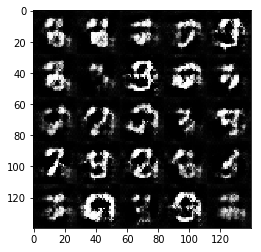

Epoch    1/2	D Loss: 0.8713	G Loss: 4.5890
Epoch    1/2	D Loss: 0.6834	G Loss: 1.5566
Epoch    1/2	D Loss: 0.7074	G Loss: 2.4996
Epoch    1/2	D Loss: 0.8201	G Loss: 1.3583
Epoch    1/2	D Loss: 0.5709	G Loss: 2.5575
Epoch    1/2	D Loss: 0.6514	G Loss: 3.4094
Epoch    1/2	D Loss: 0.7413	G Loss: 2.4712
Epoch    1/2	D Loss: 0.6973	G Loss: 1.6745
Epoch    1/2	D Loss: 0.6937	G Loss: 1.7170
Epoch    1/2	D Loss: 0.7458	G Loss: 2.1101


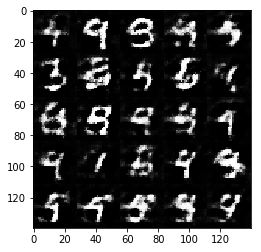

Epoch    1/2	D Loss: 0.7573	G Loss: 1.9392
Epoch    1/2	D Loss: 0.6598	G Loss: 2.0834
Epoch    1/2	D Loss: 0.6572	G Loss: 2.1327
Epoch    1/2	D Loss: 0.8925	G Loss: 1.2501
Epoch    1/2	D Loss: 0.8014	G Loss: 1.3500
Epoch    1/2	D Loss: 0.9746	G Loss: 1.0863
Epoch    1/2	D Loss: 0.9267	G Loss: 1.1058
Epoch    1/2	D Loss: 0.9204	G Loss: 1.3181
Epoch    1/2	D Loss: 0.8316	G Loss: 1.2680
Epoch    1/2	D Loss: 0.8029	G Loss: 1.3076


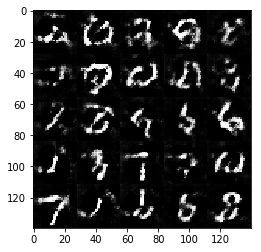

Epoch    1/2	D Loss: 0.6925	G Loss: 1.9116
Epoch    1/2	D Loss: 0.7531	G Loss: 1.4152
Epoch    1/2	D Loss: 0.7847	G Loss: 1.6593
Epoch    1/2	D Loss: 0.6475	G Loss: 2.1278
Epoch    1/2	D Loss: 0.8535	G Loss: 2.4892
Epoch    1/2	D Loss: 0.9115	G Loss: 1.0949
Epoch    1/2	D Loss: 0.7487	G Loss: 1.6566
Epoch    1/2	D Loss: 1.0252	G Loss: 0.9649
Epoch    1/2	D Loss: 0.7048	G Loss: 1.7763
Epoch    1/2	D Loss: 0.7818	G Loss: 1.5783


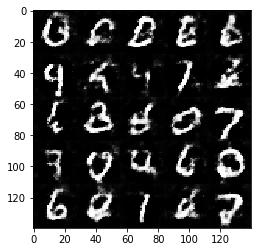

Epoch    1/2	D Loss: 0.6805	G Loss: 2.0174
Epoch    1/2	D Loss: 0.8892	G Loss: 1.1280
Epoch    1/2	D Loss: 0.7453	G Loss: 1.3779
Epoch    1/2	D Loss: 0.8776	G Loss: 1.0799
Epoch    1/2	D Loss: 0.8103	G Loss: 1.1811
Epoch    1/2	D Loss: 0.9224	G Loss: 1.3994
Epoch    1/2	D Loss: 0.9267	G Loss: 1.3583
Epoch    1/2	D Loss: 0.8882	G Loss: 1.0567
Epoch    1/2	D Loss: 1.4027	G Loss: 4.4423
Epoch    1/2	D Loss: 0.9110	G Loss: 1.0579


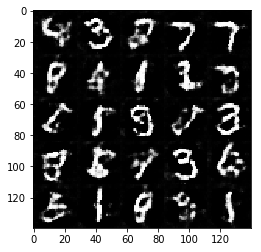

Epoch    1/2	D Loss: 0.7368	G Loss: 1.5212
Epoch    1/2	D Loss: 0.7762	G Loss: 1.4277
Epoch    1/2	D Loss: 0.9911	G Loss: 1.0042
Epoch    1/2	D Loss: 0.7464	G Loss: 1.9235
Epoch    1/2	D Loss: 0.7933	G Loss: 1.9080
Epoch    1/2	D Loss: 0.8795	G Loss: 1.1574
Epoch    1/2	D Loss: 0.9161	G Loss: 1.1267
Epoch    1/2	D Loss: 0.7878	G Loss: 1.3295
Epoch    1/2	D Loss: 0.8930	G Loss: 2.7561
Epoch    1/2	D Loss: 0.9054	G Loss: 1.1521


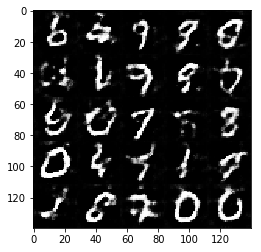

Epoch    1/2	D Loss: 0.7649	G Loss: 1.8297
Epoch    1/2	D Loss: 0.8493	G Loss: 1.3175
Epoch    1/2	D Loss: 0.7864	G Loss: 2.2216
Epoch    1/2	D Loss: 0.7756	G Loss: 1.4550
Epoch    2/2	D Loss: 1.1944	G Loss: 0.6905
Epoch    2/2	D Loss: 0.6502	G Loss: 1.7488
Epoch    2/2	D Loss: 1.0225	G Loss: 0.8520
Epoch    2/2	D Loss: 0.7732	G Loss: 1.3769
Epoch    2/2	D Loss: 1.0271	G Loss: 2.6818
Epoch    2/2	D Loss: 0.7516	G Loss: 1.4053


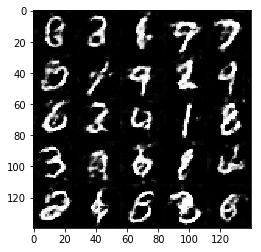

Epoch    2/2	D Loss: 1.0441	G Loss: 0.7491
Epoch    2/2	D Loss: 1.1052	G Loss: 0.7298
Epoch    2/2	D Loss: 0.8862	G Loss: 1.2222
Epoch    2/2	D Loss: 0.9753	G Loss: 0.9640
Epoch    2/2	D Loss: 0.8024	G Loss: 1.1773
Epoch    2/2	D Loss: 0.6948	G Loss: 1.9623
Epoch    2/2	D Loss: 0.7887	G Loss: 1.5778
Epoch    2/2	D Loss: 0.8193	G Loss: 1.1773
Epoch    2/2	D Loss: 1.2370	G Loss: 0.7154
Epoch    2/2	D Loss: 0.7686	G Loss: 1.3144


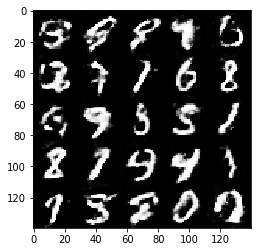

Epoch    2/2	D Loss: 0.6873	G Loss: 1.5119
Epoch    2/2	D Loss: 1.7321	G Loss: 0.4045
Epoch    2/2	D Loss: 0.9422	G Loss: 0.9356
Epoch    2/2	D Loss: 0.7129	G Loss: 1.4756
Epoch    2/2	D Loss: 1.0225	G Loss: 0.8344
Epoch    2/2	D Loss: 0.9375	G Loss: 1.0060
Epoch    2/2	D Loss: 1.3050	G Loss: 0.6483
Epoch    2/2	D Loss: 0.6945	G Loss: 1.5155
Epoch    2/2	D Loss: 0.8425	G Loss: 1.0872
Epoch    2/2	D Loss: 0.7976	G Loss: 1.8282


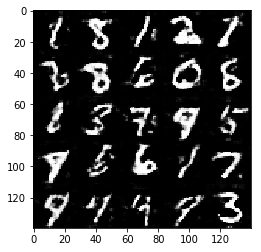

Epoch    2/2	D Loss: 0.8639	G Loss: 1.1381
Epoch    2/2	D Loss: 1.2321	G Loss: 0.6274
Epoch    2/2	D Loss: 0.7608	G Loss: 1.2480
Epoch    2/2	D Loss: 1.0218	G Loss: 0.8553
Epoch    2/2	D Loss: 0.8519	G Loss: 1.1579
Epoch    2/2	D Loss: 1.5605	G Loss: 2.9590
Epoch    2/2	D Loss: 0.7185	G Loss: 1.6662
Epoch    2/2	D Loss: 0.7791	G Loss: 1.4539
Epoch    2/2	D Loss: 0.8158	G Loss: 1.1084
Epoch    2/2	D Loss: 0.7914	G Loss: 1.2257


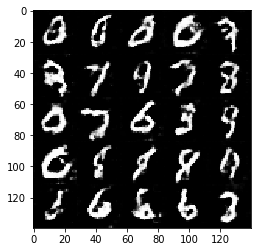

Epoch    2/2	D Loss: 1.3204	G Loss: 0.5582
Epoch    2/2	D Loss: 1.3203	G Loss: 0.6238
Epoch    2/2	D Loss: 0.8996	G Loss: 1.1016
Epoch    2/2	D Loss: 0.9168	G Loss: 0.9119
Epoch    2/2	D Loss: 0.6693	G Loss: 1.6037
Epoch    2/2	D Loss: 0.7361	G Loss: 1.3647
Epoch    2/2	D Loss: 0.8670	G Loss: 1.0930
Epoch    2/2	D Loss: 0.8968	G Loss: 0.9944
Epoch    2/2	D Loss: 0.6062	G Loss: 1.9142
Epoch    2/2	D Loss: 1.6806	G Loss: 0.5488


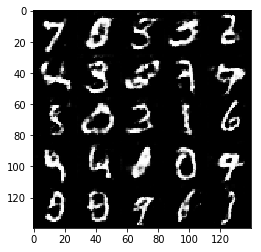

Epoch    2/2	D Loss: 0.9038	G Loss: 0.9952
Epoch    2/2	D Loss: 0.8614	G Loss: 1.0887
Epoch    2/2	D Loss: 0.6952	G Loss: 1.4130
Epoch    2/2	D Loss: 0.6641	G Loss: 1.9695
Epoch    2/2	D Loss: 0.6812	G Loss: 1.5035
Epoch    2/2	D Loss: 0.7542	G Loss: 1.6793
Epoch    2/2	D Loss: 0.8599	G Loss: 1.1201
Epoch    2/2	D Loss: 1.2820	G Loss: 0.5697
Epoch    2/2	D Loss: 0.7720	G Loss: 1.4881
Epoch    2/2	D Loss: 0.7101	G Loss: 2.0266


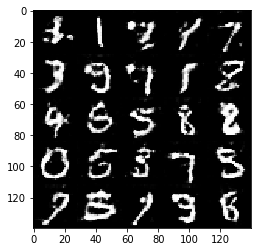

Epoch    2/2	D Loss: 1.2070	G Loss: 4.4565
Epoch    2/2	D Loss: 0.7384	G Loss: 1.6745
Epoch    2/2	D Loss: 1.3148	G Loss: 2.9402
Epoch    2/2	D Loss: 0.9390	G Loss: 0.9575
Epoch    2/2	D Loss: 1.2020	G Loss: 0.6592
Epoch    2/2	D Loss: 0.6656	G Loss: 1.5668
Epoch    2/2	D Loss: 0.6373	G Loss: 1.5872
Epoch    2/2	D Loss: 0.9002	G Loss: 0.9764
Epoch    2/2	D Loss: 0.6311	G Loss: 1.5175
Epoch    2/2	D Loss: 2.4863	G Loss: 0.2138


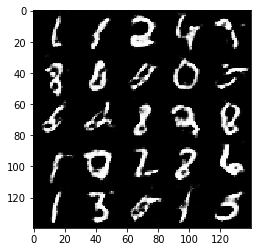

Epoch    2/2	D Loss: 0.8037	G Loss: 1.1964
Epoch    2/2	D Loss: 0.7391	G Loss: 1.6298
Epoch    2/2	D Loss: 0.7381	G Loss: 1.4207
Epoch    2/2	D Loss: 1.1175	G Loss: 0.6846
Epoch    2/2	D Loss: 0.7441	G Loss: 1.2626
Epoch    2/2	D Loss: 1.0658	G Loss: 0.8322
Epoch    2/2	D Loss: 0.8225	G Loss: 1.2752
Epoch    2/2	D Loss: 1.3378	G Loss: 0.5345
Epoch    2/2	D Loss: 0.8105	G Loss: 1.1674
Epoch    2/2	D Loss: 0.9829	G Loss: 0.8993


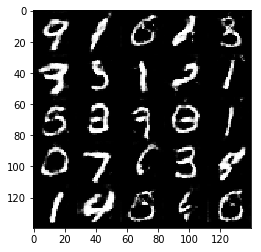

Epoch    2/2	D Loss: 1.1086	G Loss: 0.7291
Epoch    2/2	D Loss: 0.7754	G Loss: 1.2262
Epoch    2/2	D Loss: 0.6350	G Loss: 1.5003
Epoch    2/2	D Loss: 0.5484	G Loss: 2.0383
Epoch    2/2	D Loss: 1.2165	G Loss: 0.6522
Epoch    2/2	D Loss: 1.0559	G Loss: 0.7717
Epoch    2/2	D Loss: 0.5221	G Loss: 2.1777
Epoch    2/2	D Loss: 1.3067	G Loss: 0.6018
Epoch    2/2	D Loss: 1.9198	G Loss: 0.3260
Epoch    2/2	D Loss: 0.7968	G Loss: 1.2164


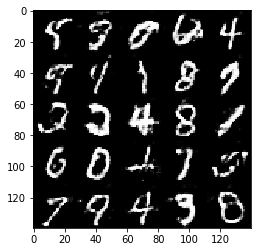

Epoch    2/2	D Loss: 0.5749	G Loss: 2.1412
Epoch    2/2	D Loss: 1.0320	G Loss: 0.7734
Epoch    2/2	D Loss: 0.7232	G Loss: 1.2799
Epoch    2/2	D Loss: 0.7992	G Loss: 2.0348
Epoch    2/2	D Loss: 0.8455	G Loss: 1.3141
Epoch    2/2	D Loss: 0.6784	G Loss: 1.4387
Epoch    2/2	D Loss: 0.8633	G Loss: 1.0273
Epoch    2/2	D Loss: 0.6021	G Loss: 2.1903


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.00005
alpha = 0.1
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha, 10)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch    1/1	D Loss: 0.6953	G Loss: 8.1493
Epoch    1/1	D Loss: 0.4836	G Loss: 10.6606
Epoch    1/1	D Loss: 0.3728	G Loss: 6.9100
Epoch    1/1	D Loss: 0.7109	G Loss: 1.2807
Epoch    1/1	D Loss: 0.3815	G Loss: 3.7003
Epoch    1/1	D Loss: 0.3949	G Loss: 3.4717
Epoch    1/1	D Loss: 0.6249	G Loss: 10.0475
Epoch    1/1	D Loss: 0.5902	G Loss: 1.5763
Epoch    1/1	D Loss: 0.5196	G Loss: 2.1034


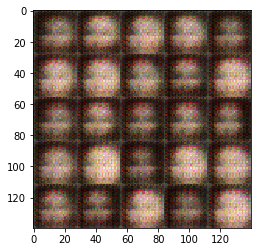

Epoch    1/1	D Loss: 2.7731	G Loss: 1.4384
Epoch    1/1	D Loss: 1.3439	G Loss: 0.5592
Epoch    1/1	D Loss: 1.0639	G Loss: 3.4327
Epoch    1/1	D Loss: 0.5632	G Loss: 2.5387
Epoch    1/1	D Loss: 0.6891	G Loss: 1.4765
Epoch    1/1	D Loss: 0.8423	G Loss: 1.7127
Epoch    1/1	D Loss: 1.5002	G Loss: 2.4364
Epoch    1/1	D Loss: 1.1406	G Loss: 0.8841
Epoch    1/1	D Loss: 0.8558	G Loss: 1.0732
Epoch    1/1	D Loss: 0.6212	G Loss: 2.7124


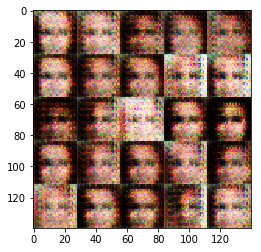

Epoch    1/1	D Loss: 1.2235	G Loss: 4.1098
Epoch    1/1	D Loss: 1.5988	G Loss: 0.4515
Epoch    1/1	D Loss: 1.9141	G Loss: 0.2936
Epoch    1/1	D Loss: 1.7429	G Loss: 4.8281
Epoch    1/1	D Loss: 0.7822	G Loss: 1.6415
Epoch    1/1	D Loss: 0.9326	G Loss: 1.3727
Epoch    1/1	D Loss: 0.9068	G Loss: 1.0766
Epoch    1/1	D Loss: 0.8757	G Loss: 1.1685
Epoch    1/1	D Loss: 1.2239	G Loss: 0.7120
Epoch    1/1	D Loss: 0.8890	G Loss: 2.6743


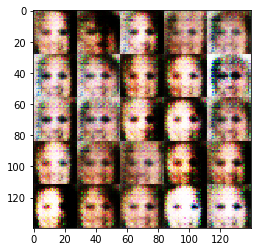

Epoch    1/1	D Loss: 1.1542	G Loss: 0.6741
Epoch    1/1	D Loss: 0.8657	G Loss: 1.6846
Epoch    1/1	D Loss: 0.9751	G Loss: 1.1481
Epoch    1/1	D Loss: 1.1980	G Loss: 0.9335
Epoch    1/1	D Loss: 1.0152	G Loss: 1.1359
Epoch    1/1	D Loss: 0.7620	G Loss: 1.6244
Epoch    1/1	D Loss: 1.1601	G Loss: 2.2509
Epoch    1/1	D Loss: 0.8016	G Loss: 1.7213
Epoch    1/1	D Loss: 0.8063	G Loss: 1.2657
Epoch    1/1	D Loss: 0.9731	G Loss: 2.1577


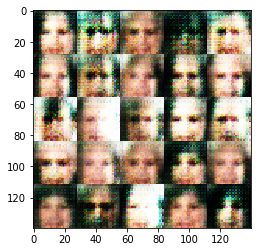

Epoch    1/1	D Loss: 0.7113	G Loss: 1.6651
Epoch    1/1	D Loss: 2.3340	G Loss: 0.1962
Epoch    1/1	D Loss: 0.9126	G Loss: 1.1661
Epoch    1/1	D Loss: 0.9724	G Loss: 1.3374
Epoch    1/1	D Loss: 0.8309	G Loss: 1.3570
Epoch    1/1	D Loss: 0.7343	G Loss: 1.6514
Epoch    1/1	D Loss: 1.1124	G Loss: 0.8434
Epoch    1/1	D Loss: 0.8427	G Loss: 1.1720
Epoch    1/1	D Loss: 1.6579	G Loss: 0.3935
Epoch    1/1	D Loss: 0.9691	G Loss: 0.9000


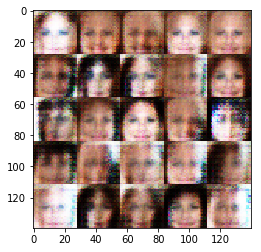

Epoch    1/1	D Loss: 0.9134	G Loss: 1.2284
Epoch    1/1	D Loss: 0.8735	G Loss: 1.9165
Epoch    1/1	D Loss: 0.8335	G Loss: 2.0481
Epoch    1/1	D Loss: 1.6360	G Loss: 0.4387
Epoch    1/1	D Loss: 1.1707	G Loss: 2.5069
Epoch    1/1	D Loss: 0.9088	G Loss: 2.0928
Epoch    1/1	D Loss: 1.1097	G Loss: 0.8304
Epoch    1/1	D Loss: 1.7726	G Loss: 3.9896
Epoch    1/1	D Loss: 0.8479	G Loss: 1.8793
Epoch    1/1	D Loss: 0.9207	G Loss: 1.1350


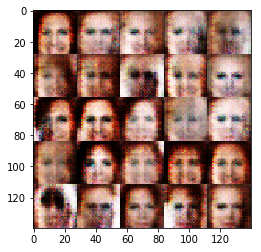

Epoch    1/1	D Loss: 1.3071	G Loss: 0.8058
Epoch    1/1	D Loss: 0.7650	G Loss: 1.4437
Epoch    1/1	D Loss: 1.1082	G Loss: 0.7855
Epoch    1/1	D Loss: 0.9439	G Loss: 1.5327
Epoch    1/1	D Loss: 0.9327	G Loss: 1.0274
Epoch    1/1	D Loss: 1.1898	G Loss: 3.4066
Epoch    1/1	D Loss: 1.5351	G Loss: 0.4767
Epoch    1/1	D Loss: 1.1995	G Loss: 0.7069
Epoch    1/1	D Loss: 1.3033	G Loss: 3.1619
Epoch    1/1	D Loss: 1.3915	G Loss: 2.7331


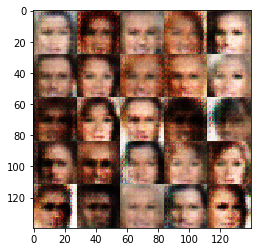

Epoch    1/1	D Loss: 1.0906	G Loss: 1.3647
Epoch    1/1	D Loss: 1.0679	G Loss: 1.4207
Epoch    1/1	D Loss: 0.9207	G Loss: 1.1114
Epoch    1/1	D Loss: 1.3818	G Loss: 2.4544
Epoch    1/1	D Loss: 1.0401	G Loss: 0.8024
Epoch    1/1	D Loss: 0.8517	G Loss: 1.7194
Epoch    1/1	D Loss: 0.8312	G Loss: 1.5847
Epoch    1/1	D Loss: 1.0161	G Loss: 0.9321
Epoch    1/1	D Loss: 0.7950	G Loss: 1.5003
Epoch    1/1	D Loss: 0.9735	G Loss: 0.8803


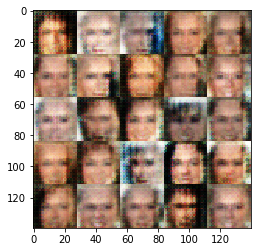

Epoch    1/1	D Loss: 1.2152	G Loss: 0.7416
Epoch    1/1	D Loss: 0.7674	G Loss: 2.4593
Epoch    1/1	D Loss: 1.0529	G Loss: 1.4077
Epoch    1/1	D Loss: 0.8185	G Loss: 1.3253
Epoch    1/1	D Loss: 0.9122	G Loss: 2.2939
Epoch    1/1	D Loss: 0.7991	G Loss: 1.4746
Epoch    1/1	D Loss: 0.9473	G Loss: 0.9921
Epoch    1/1	D Loss: 0.9667	G Loss: 2.1698
Epoch    1/1	D Loss: 0.7383	G Loss: 1.6548
Epoch    1/1	D Loss: 0.9001	G Loss: 1.2564


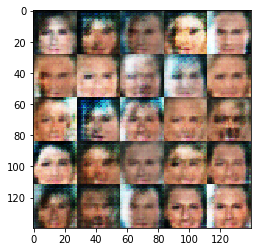

Epoch    1/1	D Loss: 0.9961	G Loss: 1.0005
Epoch    1/1	D Loss: 1.0010	G Loss: 0.8889
Epoch    1/1	D Loss: 0.7387	G Loss: 1.6401
Epoch    1/1	D Loss: 0.6922	G Loss: 2.4020
Epoch    1/1	D Loss: 0.6568	G Loss: 1.5703
Epoch    1/1	D Loss: 0.9554	G Loss: 0.9418
Epoch    1/1	D Loss: 0.9752	G Loss: 2.2269
Epoch    1/1	D Loss: 0.9370	G Loss: 1.2722
Epoch    1/1	D Loss: 1.2716	G Loss: 0.6201
Epoch    1/1	D Loss: 1.1246	G Loss: 3.4537


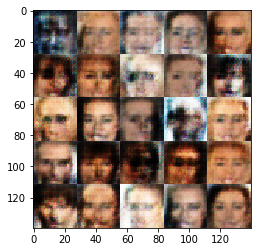

Epoch    1/1	D Loss: 0.9088	G Loss: 1.2461
Epoch    1/1	D Loss: 1.0343	G Loss: 1.7808
Epoch    1/1	D Loss: 0.8918	G Loss: 1.0216
Epoch    1/1	D Loss: 1.1480	G Loss: 0.7362
Epoch    1/1	D Loss: 0.7087	G Loss: 2.3941
Epoch    1/1	D Loss: 0.7745	G Loss: 1.5591
Epoch    1/1	D Loss: 0.8017	G Loss: 2.0448
Epoch    1/1	D Loss: 0.8701	G Loss: 1.6197
Epoch    1/1	D Loss: 0.7260	G Loss: 1.5800
Epoch    1/1	D Loss: 0.7190	G Loss: 2.2306


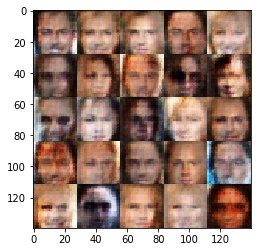

Epoch    1/1	D Loss: 1.3520	G Loss: 0.5735
Epoch    1/1	D Loss: 0.8176	G Loss: 1.3360
Epoch    1/1	D Loss: 0.8833	G Loss: 1.1127
Epoch    1/1	D Loss: 0.8432	G Loss: 1.2923
Epoch    1/1	D Loss: 0.9244	G Loss: 0.9316
Epoch    1/1	D Loss: 0.8601	G Loss: 1.7589
Epoch    1/1	D Loss: 0.8464	G Loss: 1.1459
Epoch    1/1	D Loss: 0.7351	G Loss: 1.6978
Epoch    1/1	D Loss: 0.8142	G Loss: 1.7898
Epoch    1/1	D Loss: 0.7725	G Loss: 1.3128


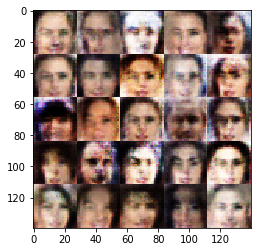

Epoch    1/1	D Loss: 0.9041	G Loss: 1.0901
Epoch    1/1	D Loss: 1.1877	G Loss: 0.7611
Epoch    1/1	D Loss: 0.9079	G Loss: 1.3998
Epoch    1/1	D Loss: 0.7224	G Loss: 1.3834
Epoch    1/1	D Loss: 0.8840	G Loss: 1.1132
Epoch    1/1	D Loss: 0.9442	G Loss: 0.9276
Epoch    1/1	D Loss: 0.7252	G Loss: 1.8190
Epoch    1/1	D Loss: 1.1745	G Loss: 0.6621
Epoch    1/1	D Loss: 1.1334	G Loss: 0.7469
Epoch    1/1	D Loss: 0.9596	G Loss: 1.3881


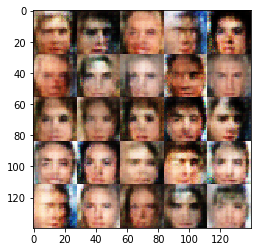

Epoch    1/1	D Loss: 0.9616	G Loss: 2.2376
Epoch    1/1	D Loss: 1.0219	G Loss: 0.9052
Epoch    1/1	D Loss: 1.1446	G Loss: 0.8081
Epoch    1/1	D Loss: 0.9548	G Loss: 1.1136
Epoch    1/1	D Loss: 0.9313	G Loss: 0.9832
Epoch    1/1	D Loss: 0.8933	G Loss: 1.0948
Epoch    1/1	D Loss: 0.8006	G Loss: 2.6098
Epoch    1/1	D Loss: 0.9149	G Loss: 1.0325
Epoch    1/1	D Loss: 0.7171	G Loss: 1.5670
Epoch    1/1	D Loss: 0.9076	G Loss: 1.2336


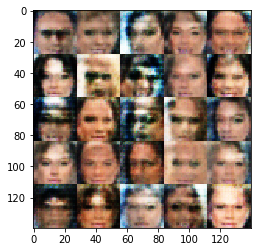

Epoch    1/1	D Loss: 1.0351	G Loss: 0.8363
Epoch    1/1	D Loss: 0.9549	G Loss: 1.0467
Epoch    1/1	D Loss: 0.8521	G Loss: 1.5373
Epoch    1/1	D Loss: 0.7341	G Loss: 1.5009
Epoch    1/1	D Loss: 0.8066	G Loss: 1.4884
Epoch    1/1	D Loss: 0.7747	G Loss: 1.5780
Epoch    1/1	D Loss: 0.8340	G Loss: 1.1422
Epoch    1/1	D Loss: 1.0587	G Loss: 1.7566
Epoch    1/1	D Loss: 1.1583	G Loss: 0.6752
Epoch    1/1	D Loss: 0.7977	G Loss: 1.2957


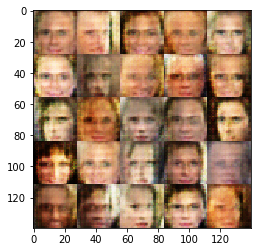

Epoch    1/1	D Loss: 0.7300	G Loss: 2.5151
Epoch    1/1	D Loss: 1.0130	G Loss: 0.9949
Epoch    1/1	D Loss: 0.9398	G Loss: 1.0286
Epoch    1/1	D Loss: 0.6033	G Loss: 1.9671
Epoch    1/1	D Loss: 1.0362	G Loss: 0.8907
Epoch    1/1	D Loss: 1.1259	G Loss: 0.7425
Epoch    1/1	D Loss: 1.2936	G Loss: 0.6042
Epoch    1/1	D Loss: 0.8873	G Loss: 1.0951
Epoch    1/1	D Loss: 1.2239	G Loss: 2.9321
Epoch    1/1	D Loss: 1.0941	G Loss: 0.7851


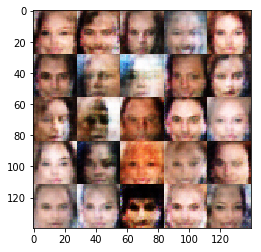

Epoch    1/1	D Loss: 1.0327	G Loss: 2.1527
Epoch    1/1	D Loss: 0.8064	G Loss: 1.5264
Epoch    1/1	D Loss: 1.4882	G Loss: 0.4741
Epoch    1/1	D Loss: 0.7883	G Loss: 1.6235
Epoch    1/1	D Loss: 0.9100	G Loss: 2.0623
Epoch    1/1	D Loss: 0.7663	G Loss: 1.8171
Epoch    1/1	D Loss: 0.8128	G Loss: 1.2510
Epoch    1/1	D Loss: 0.7415	G Loss: 1.8441
Epoch    1/1	D Loss: 0.8708	G Loss: 1.1349
Epoch    1/1	D Loss: 0.8417	G Loss: 1.2532


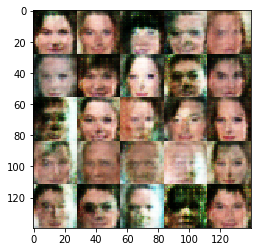

Epoch    1/1	D Loss: 0.9352	G Loss: 1.2028
Epoch    1/1	D Loss: 0.7746	G Loss: 1.6550
Epoch    1/1	D Loss: 1.0314	G Loss: 2.3913
Epoch    1/1	D Loss: 1.3828	G Loss: 3.6387
Epoch    1/1	D Loss: 0.8036	G Loss: 1.3476
Epoch    1/1	D Loss: 0.7756	G Loss: 1.4402
Epoch    1/1	D Loss: 1.1434	G Loss: 0.7465
Epoch    1/1	D Loss: 0.7812	G Loss: 1.4448
Epoch    1/1	D Loss: 0.7547	G Loss: 1.7161
Epoch    1/1	D Loss: 0.9702	G Loss: 2.6909


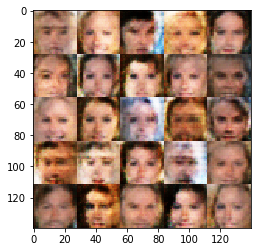

Epoch    1/1	D Loss: 0.6473	G Loss: 1.7399
Epoch    1/1	D Loss: 0.9224	G Loss: 1.9883
Epoch    1/1	D Loss: 1.1387	G Loss: 0.7294
Epoch    1/1	D Loss: 0.8304	G Loss: 1.1301
Epoch    1/1	D Loss: 0.6057	G Loss: 2.2388
Epoch    1/1	D Loss: 0.6427	G Loss: 1.6037
Epoch    1/1	D Loss: 0.8403	G Loss: 1.1346
Epoch    1/1	D Loss: 1.2453	G Loss: 0.6246
Epoch    1/1	D Loss: 1.2474	G Loss: 2.0926
Epoch    1/1	D Loss: 0.8683	G Loss: 1.1343


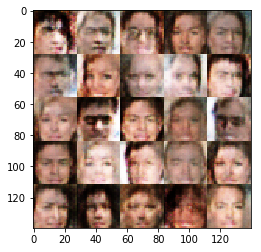

Epoch    1/1	D Loss: 1.0483	G Loss: 0.7999
Epoch    1/1	D Loss: 0.7656	G Loss: 1.3638
Epoch    1/1	D Loss: 0.7989	G Loss: 1.8995
Epoch    1/1	D Loss: 0.8499	G Loss: 1.2865
Epoch    1/1	D Loss: 0.8673	G Loss: 1.0498
Epoch    1/1	D Loss: 0.7984	G Loss: 1.3516
Epoch    1/1	D Loss: 0.8682	G Loss: 1.1246
Epoch    1/1	D Loss: 0.8109	G Loss: 1.1797
Epoch    1/1	D Loss: 1.1449	G Loss: 0.7118
Epoch    1/1	D Loss: 0.8586	G Loss: 1.1130


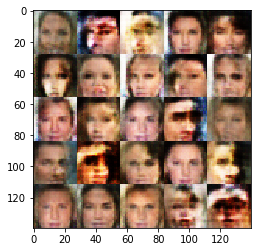

Epoch    1/1	D Loss: 1.0850	G Loss: 0.7623
Epoch    1/1	D Loss: 0.7756	G Loss: 1.5332
Epoch    1/1	D Loss: 0.5514	G Loss: 2.6365
Epoch    1/1	D Loss: 0.7825	G Loss: 1.5008
Epoch    1/1	D Loss: 1.1028	G Loss: 0.7234
Epoch    1/1	D Loss: 0.7941	G Loss: 1.4771
Epoch    1/1	D Loss: 0.7239	G Loss: 1.3556
Epoch    1/1	D Loss: 0.8683	G Loss: 1.1613
Epoch    1/1	D Loss: 0.8205	G Loss: 1.2183
Epoch    1/1	D Loss: 0.6172	G Loss: 1.8975


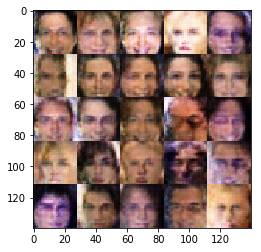

Epoch    1/1	D Loss: 0.9198	G Loss: 1.1085
Epoch    1/1	D Loss: 0.8271	G Loss: 1.3643
Epoch    1/1	D Loss: 0.7347	G Loss: 2.3940
Epoch    1/1	D Loss: 0.8576	G Loss: 2.3587
Epoch    1/1	D Loss: 0.8481	G Loss: 1.2558
Epoch    1/1	D Loss: 0.8354	G Loss: 2.3661
Epoch    1/1	D Loss: 0.8714	G Loss: 1.1030
Epoch    1/1	D Loss: 0.7233	G Loss: 1.8281
Epoch    1/1	D Loss: 0.9085	G Loss: 0.9845
Epoch    1/1	D Loss: 0.7353	G Loss: 1.5224


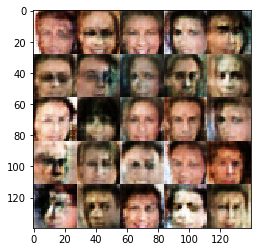

Epoch    1/1	D Loss: 0.8350	G Loss: 1.3315
Epoch    1/1	D Loss: 0.7381	G Loss: 1.7753
Epoch    1/1	D Loss: 0.9762	G Loss: 2.3105
Epoch    1/1	D Loss: 1.0405	G Loss: 0.7828
Epoch    1/1	D Loss: 1.3498	G Loss: 0.5535
Epoch    1/1	D Loss: 0.6150	G Loss: 2.0767
Epoch    1/1	D Loss: 0.8411	G Loss: 1.1114
Epoch    1/1	D Loss: 0.7284	G Loss: 1.5247
Epoch    1/1	D Loss: 1.0965	G Loss: 0.7508
Epoch    1/1	D Loss: 0.7035	G Loss: 1.6913


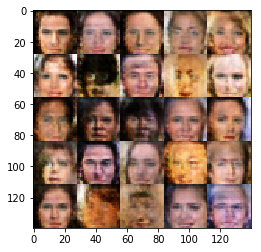

Epoch    1/1	D Loss: 1.0228	G Loss: 0.7970
Epoch    1/1	D Loss: 0.8693	G Loss: 1.9161
Epoch    1/1	D Loss: 0.7304	G Loss: 1.3607
Epoch    1/1	D Loss: 0.8793	G Loss: 1.1139
Epoch    1/1	D Loss: 0.7071	G Loss: 1.5263
Epoch    1/1	D Loss: 0.8116	G Loss: 1.4018
Epoch    1/1	D Loss: 0.8005	G Loss: 2.9417
Epoch    1/1	D Loss: 0.7067	G Loss: 1.4858
Epoch    1/1	D Loss: 0.8705	G Loss: 1.7097
Epoch    1/1	D Loss: 0.8624	G Loss: 1.6059


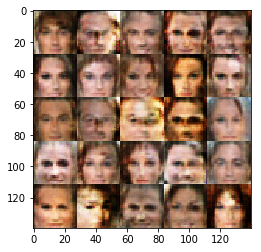

Epoch    1/1	D Loss: 1.4991	G Loss: 0.4331
Epoch    1/1	D Loss: 1.2770	G Loss: 0.5928
Epoch    1/1	D Loss: 0.8839	G Loss: 1.6485
Epoch    1/1	D Loss: 0.9232	G Loss: 0.9908
Epoch    1/1	D Loss: 0.9900	G Loss: 0.8720
Epoch    1/1	D Loss: 1.4236	G Loss: 3.8488
Epoch    1/1	D Loss: 0.9902	G Loss: 0.9303
Epoch    1/1	D Loss: 0.7039	G Loss: 2.0495
Epoch    1/1	D Loss: 0.7532	G Loss: 1.5499
Epoch    1/1	D Loss: 1.0928	G Loss: 0.8286


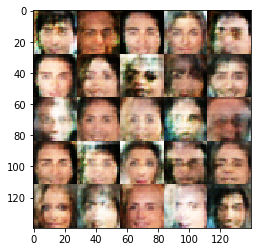

Epoch    1/1	D Loss: 0.7673	G Loss: 2.0138
Epoch    1/1	D Loss: 1.0080	G Loss: 0.8337
Epoch    1/1	D Loss: 0.6308	G Loss: 1.9491
Epoch    1/1	D Loss: 1.2401	G Loss: 0.5910
Epoch    1/1	D Loss: 1.0381	G Loss: 0.8546
Epoch    1/1	D Loss: 0.8876	G Loss: 2.0361
Epoch    1/1	D Loss: 0.7673	G Loss: 1.8343
Epoch    1/1	D Loss: 0.7523	G Loss: 1.3628
Epoch    1/1	D Loss: 1.1735	G Loss: 0.7320
Epoch    1/1	D Loss: 0.9145	G Loss: 0.9702


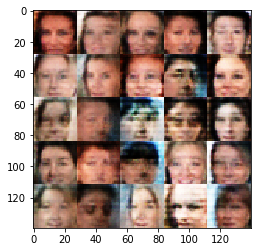

Epoch    1/1	D Loss: 0.9086	G Loss: 1.3954
Epoch    1/1	D Loss: 0.8507	G Loss: 1.7211
Epoch    1/1	D Loss: 0.6582	G Loss: 1.6768
Epoch    1/1	D Loss: 0.7647	G Loss: 1.3016
Epoch    1/1	D Loss: 0.7948	G Loss: 1.4908
Epoch    1/1	D Loss: 0.9961	G Loss: 1.0577
Epoch    1/1	D Loss: 0.9624	G Loss: 2.8096
Epoch    1/1	D Loss: 0.6371	G Loss: 2.6092
Epoch    1/1	D Loss: 0.7820	G Loss: 1.7934
Epoch    1/1	D Loss: 0.8821	G Loss: 1.0535


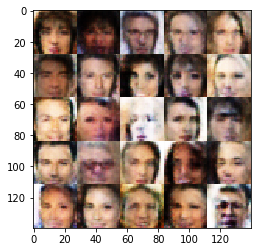

Epoch    1/1	D Loss: 0.8273	G Loss: 1.1095
Epoch    1/1	D Loss: 0.5762	G Loss: 1.9999
Epoch    1/1	D Loss: 1.1435	G Loss: 0.6707
Epoch    1/1	D Loss: 1.2893	G Loss: 0.5370
Epoch    1/1	D Loss: 0.9372	G Loss: 0.9133
Epoch    1/1	D Loss: 1.0361	G Loss: 0.8500
Epoch    1/1	D Loss: 0.7688	G Loss: 1.9991
Epoch    1/1	D Loss: 0.9779	G Loss: 0.8867
Epoch    1/1	D Loss: 0.8459	G Loss: 1.4952
Epoch    1/1	D Loss: 0.8878	G Loss: 1.1162


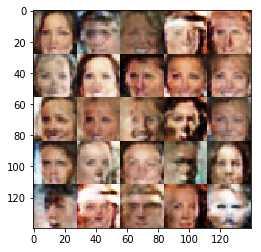

Epoch    1/1	D Loss: 0.6839	G Loss: 1.7367
Epoch    1/1	D Loss: 1.2087	G Loss: 2.9893
Epoch    1/1	D Loss: 0.8598	G Loss: 1.1076
Epoch    1/1	D Loss: 0.8112	G Loss: 1.2882
Epoch    1/1	D Loss: 0.6742	G Loss: 1.7444
Epoch    1/1	D Loss: 0.7260	G Loss: 1.3401
Epoch    1/1	D Loss: 0.7832	G Loss: 1.5040
Epoch    1/1	D Loss: 0.7169	G Loss: 2.1291
Epoch    1/1	D Loss: 0.6993	G Loss: 1.4320
Epoch    1/1	D Loss: 0.6633	G Loss: 1.8917


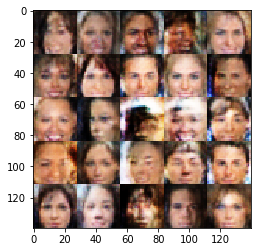

Epoch    1/1	D Loss: 0.7690	G Loss: 1.4125
Epoch    1/1	D Loss: 0.7966	G Loss: 1.8703
Epoch    1/1	D Loss: 0.8674	G Loss: 1.7409
Epoch    1/1	D Loss: 0.9402	G Loss: 0.9387
Epoch    1/1	D Loss: 0.8818	G Loss: 1.0096
Epoch    1/1	D Loss: 1.1261	G Loss: 0.7372
Epoch    1/1	D Loss: 0.9015	G Loss: 1.1913
Epoch    1/1	D Loss: 0.7096	G Loss: 1.8850
Epoch    1/1	D Loss: 0.7523	G Loss: 1.2639
Epoch    1/1	D Loss: 1.4022	G Loss: 0.4941


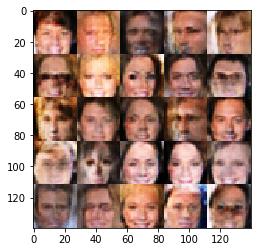

Epoch    1/1	D Loss: 0.8687	G Loss: 1.1673
Epoch    1/1	D Loss: 0.7252	G Loss: 1.6367
Epoch    1/1	D Loss: 1.0331	G Loss: 0.8999
Epoch    1/1	D Loss: 1.2226	G Loss: 0.6315
Epoch    1/1	D Loss: 0.8150	G Loss: 1.1800
Epoch    1/1	D Loss: 0.8923	G Loss: 1.0639
Epoch    1/1	D Loss: 1.2795	G Loss: 0.5985
Epoch    1/1	D Loss: 0.7074	G Loss: 1.3592
Epoch    1/1	D Loss: 0.8891	G Loss: 2.6872
Epoch    1/1	D Loss: 0.7646	G Loss: 1.6630


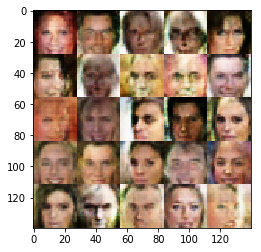

Epoch    1/1	D Loss: 0.8206	G Loss: 1.2169
Epoch    1/1	D Loss: 0.7788	G Loss: 1.2738
Epoch    1/1	D Loss: 0.6824	G Loss: 2.0289
Epoch    1/1	D Loss: 0.8495	G Loss: 1.7727
Epoch    1/1	D Loss: 1.2342	G Loss: 0.7151
Epoch    1/1	D Loss: 1.1422	G Loss: 0.7472
Epoch    1/1	D Loss: 0.8196	G Loss: 1.1770


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.1
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 10)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.